# Denoising scATACseq

In this tutorial, we will walk through the steps for denoising peak counts in species-mixing scATACseq data.   

In this experiment, an equal number of human GM12878 nuclei and mouse EL4 nuclei were pooled and sequenced, ATAC signals from the other organism were unambiguously ambient contamination. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/10k-1-1-mixture-of-human-gm12878-and-mouse-el4-cells-atac-v2-chromium-controller-2-standard).

<div class="alert alert-info">

Note

To run this notebook on your device, you need to install [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can also run this notebook on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_denoising_scATACseq.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scar import model, setup_anndata

import warnings
warnings.simplefilter("ignore")

## Download data

The raw and filtered count matrices can be downloaded from 10x Dataset.

### The raw data

cellranger output: raw_peak_bc_matrix

In [2]:
hgmm10k_scATACseq_raw = sc.read_10x_h5(filename='10k_hgmm_ATACv2_nextgem_Chromium_Controller_raw_peak_bc_matrix.h5', 
                                       backup_url='https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_hgmm_ATACv2_nextgem_Chromium_Controller/10k_hgmm_ATACv2_nextgem_Chromium_Controller_raw_peak_bc_matrix.h5',
                                      gex_only=False);
hgmm10k_scATACseq_raw.var_names_make_unique();

### The filtered data

cellranger output: filtered_peak_bc_matrix

In [3]:
hgmm10k_scATACseq = sc.read_10x_h5(filename='10k_hgmm_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5',
                                   backup_url='https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_hgmm_ATACv2_nextgem_Chromium_Controller/10k_hgmm_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5',
                                   gex_only=False);
hgmm10k_scATACseq.var_names_make_unique();

In [4]:
sc.pp.calculate_qc_metrics(hgmm10k_scATACseq, inplace=True)

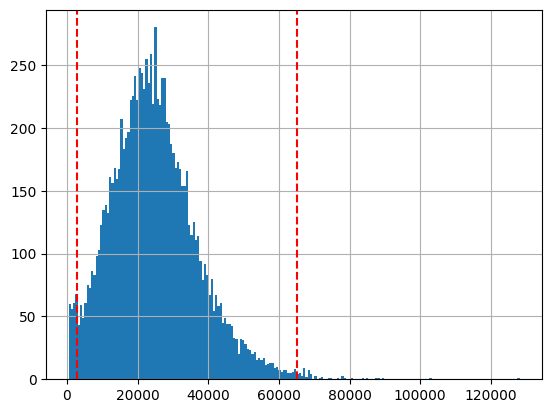

In [5]:
hgmm10k_scATACseq.obs['total_counts'].hist(bins=200);
plt.axvline(3000, c='r', ls='--')
plt.axvline(65000, c='r', ls='--')

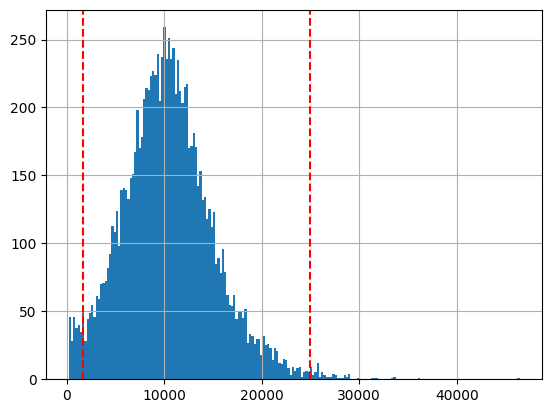

In [6]:
hgmm10k_scATACseq.obs['n_genes_by_counts'].hist(bins=200);
plt.axvline(1700, c='r', ls='--')
plt.axvline(25000, c='r', ls='--')

In [7]:
hgmm10k_scATACseq.var.head()

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
GRCh38_chr1:181026-181833,GRCh38_chr1:181026-181833,Peaks,GRCh38,84,0.014667,0.014561,99.215247,157.0,5.062595
GRCh38_chr1:267559-268474,GRCh38_chr1:267559-268474,Peaks,GRCh38,78,0.014481,0.014377,99.271300,155.0,5.049856
GRCh38_chr1:585752-586649,GRCh38_chr1:585752-586649,Peaks,GRCh38,62,0.011584,0.011518,99.420777,124.0,4.828314
GRCh38_chr1:605062-605946,GRCh38_chr1:605062-605946,Peaks,GRCh38,45,0.008315,0.008280,99.579596,89.0,4.499810
GRCh38_chr1:627577-628437,GRCh38_chr1:627577-628437,Peaks,GRCh38,26,0.004858,0.004846,99.757100,52.0,3.970292


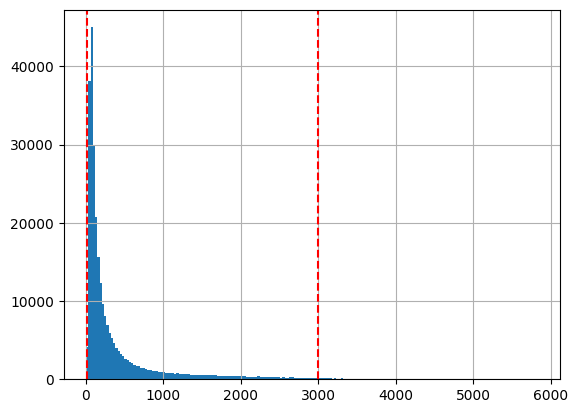

In [8]:
hgmm10k_scATACseq.var['n_cells_by_counts'].hist(bins=200);
plt.axvline(20, c='r', ls='--')
plt.axvline(3000, c='r', ls='--')

In [9]:
def count_peaks(count_matrix):
    
    count_matrix['human peak counts'] = count_matrix.loc[:,count_matrix.columns.str.startswith('GRCh38_')].sum(axis=1)
    count_matrix['mouse peak counts'] = count_matrix.loc[:,count_matrix.columns.str.startswith('mm10_')].sum(axis=1)
    count_matrix['human count ratio'] = count_matrix['human peak counts']/(count_matrix['mouse peak counts'] + count_matrix['human peak counts'])
    count_matrix['mouse count ratio'] = count_matrix['mouse peak counts']/(count_matrix['mouse peak counts'] + count_matrix['human peak counts'])
    count_matrix['log2(human peak counts+1)'] = np.log2(count_matrix['human peak counts']+1)
    count_matrix['log2(mouse peak counts+1)'] = np.log2(count_matrix['mouse peak counts']+1)
    
    return count_matrix

In [10]:
raw_counts_df = count_peaks(hgmm10k_scATACseq.to_df())
raw_counts_df.head()

,GRCh38_chr1:181026-181833,GRCh38_chr1:267559-268474,GRCh38_chr1:585752-586649,GRCh38_chr1:605062-605946,GRCh38_chr1:627577-628437,GRCh38_chr1:629502-630395,GRCh38_chr1:633580-634524,GRCh38_chr1:774767-775667,GRCh38_chr1:778276-779184,GRCh38_chr1:804456-805339,...,mm10_GL456216.1:48764-49669,mm10_GL456216.1:50644-51513,mm10_JH584292.1:12471-13336,mm10_JH584295.1:1363-1976,human peak counts,mouse peak counts,human count ratio,mouse count ratio,log2(human peak counts+1),log2(mouse peak counts+1)
AAACGAAAGATGTTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15098.0,53.0,0.996502,0.003498,13.882165,5.754888
AAACGAAAGCTTACCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,29116.0,88.0,0.996987,0.003013,14.829574,6.475733
AAACGAACAACTCGTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,43215.0,115.0,0.997346,0.002654,15.399278,6.857981
AAACGAACACAGAAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,21873.0,64.0,0.997083,0.002917,14.416929,6.022368
AAACGAACATAAAGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,28620.0,120.0,0.995825,0.004175,14.804787,6.918863


## Cell annotation

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(raw_counts_df[['human count ratio', 'mouse count ratio']].values)
raw_counts_df['clusters'] = kmeans.labels_
raw_counts_df['species'] = raw_counts_df['clusters'].map({0: 'EL4', 1: 'GM12878', 2: 'mixture'})

<Figure size 300x300 with 0 Axes>

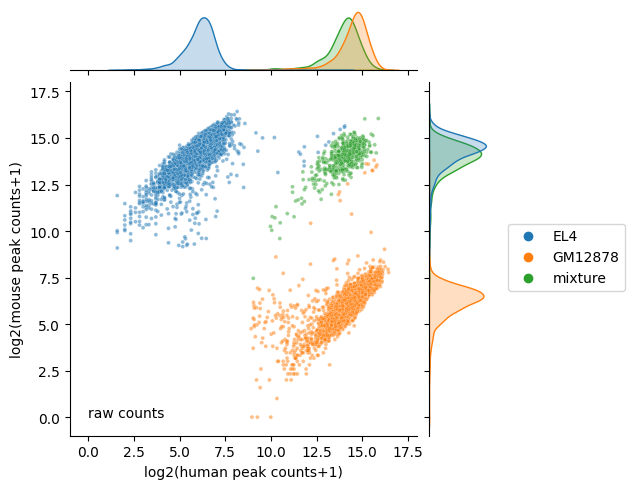

In [12]:
plt.figure(figsize=(2, 2), dpi=150)

ax = sns.jointplot(data=raw_counts_df,
                   x="log2(human peak counts+1)",
                   y="log2(mouse peak counts+1)",
                   hue='species',
                   hue_order=['EL4', 'GM12878', 'mixture'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   rasterized=True,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'raw counts');

ax.ax_joint.set_xlim(-1, 18);
ax.ax_joint.set_ylim(-1, 18);
ax.ax_joint.legend(bbox_to_anchor=(1.6, 0.6),borderaxespad=0)

In [13]:
hgmm10k_scATACseq.obs['species'] = raw_counts_df['species']

## Run scar

In [14]:
sc.pp.filter_genes(hgmm10k_scATACseq, min_counts=3000);
sc.pp.filter_genes(hgmm10k_scATACseq, max_counts=6500);
sc.pp.filter_cells(hgmm10k_scATACseq, min_genes=1700);

2023-05-01 17:46:36|INFO|setup_anndata|Randomly sample 234078 droplets from 234078 droplets.
2023-05-01 17:46:37|INFO|setup_anndata|Estimating ambient profile for ['Peaks']...
2023-05-01 17:47:00|INFO|setup_anndata|Iteration: 1
2023-05-01 17:47:22|INFO|setup_anndata|Iteration: 2
2023-05-01 17:47:45|INFO|setup_anndata|Iteration: 3
2023-05-01 17:47:45|INFO|setup_anndata|Estimated ambient profile for Peaks saved in adata.uns
2023-05-01 17:47:45|INFO|setup_anndata|Estimated ambient profile for all features saved in adata.uns


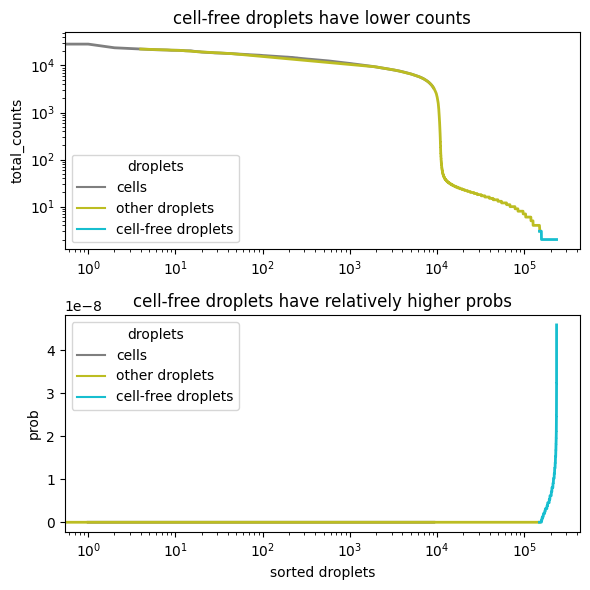

In [15]:
setup_anndata(
    adata = hgmm10k_scATACseq,
    raw_adata = hgmm10k_scATACseq_raw,
    prob = 0.998,
    kneeplot = True
)

In [16]:
hgmm10k_scATACseq.uns['ambient_profile_Peaks']

,ambient_profile_Peaks
GRCh38_chr1:778276-779184,0.000034
GRCh38_chr1:958857-959725,0.000034
GRCh38_chr1:1012966-1013877,0.000022
GRCh38_chr1:1019134-1020005,0.000101
GRCh38_chr1:1032743-1033658,0.000028
...,...
mm10_chrX:166479303-166480165,0.000073
mm10_chrX:167382297-167383097,0.000056
mm10_chrX:169986707-169987568,0.000034
mm10_chrY:90741457-90742113,0.000062


In [17]:
raw_counts = hgmm10k_scATACseq.to_df()
raw_counts.head()

,GRCh38_chr1:778276-779184,GRCh38_chr1:958857-959725,GRCh38_chr1:1012966-1013877,GRCh38_chr1:1019134-1020005,GRCh38_chr1:1032743-1033658,GRCh38_chr1:1059198-1060047,GRCh38_chr1:1063769-1064659,GRCh38_chr1:1231630-1232529,GRCh38_chr1:1273493-1274386,GRCh38_chr1:1324324-1325228,...,mm10_chrX:163549410-163550287,mm10_chrX:163879142-163880015,mm10_chrX:163958369-163958813,mm10_chrX:164381674-164382588,mm10_chrX:166440266-166441175,mm10_chrX:166479303-166480165,mm10_chrX:167382297-167383097,mm10_chrX:169986707-169987568,mm10_chrY:90741457-90742113,mm10_JH584304.1:26551-27398
AAACGAAAGATGTTCC-1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGCTTACCA-1,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAACAACTCGTA-1,0.0,4.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAACACAGAAGC-1,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAACATAAAGTG-1,4.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ambient_profile = hgmm10k_scATACseq.uns["ambient_profile_Peaks"]
ambient_profile.head()

,ambient_profile_Peaks
GRCh38_chr1:778276-779184,0.000034
GRCh38_chr1:958857-959725,0.000034
GRCh38_chr1:1012966-1013877,0.000022
GRCh38_chr1:1019134-1020005,0.000101
GRCh38_chr1:1032743-1033658,0.000028


In [19]:
hgmm_10k_ATAC_scar = model(raw_count = raw_counts,
                           ambient_profile = ambient_profile, # In the case of default None, the ambient_profile will be calculated by averaging pooled cells
                           feature_type='ATAC',
                           sparsity=1,
                           device='cuda'
                          )

hgmm_10k_ATAC_scar.train(epochs=500,
                         batch_size=64,
                         verbose=True
                        )

# After training, we can infer the native true signal
hgmm_10k_ATAC_scar.inference()  # by defaut, batch_size = None, set a batch_size if getting a GPU memory issue

2023-05-01 17:47:48|INFO|model|cuda will be used.
2023-05-01 17:47:51|INFO|VAE|Running VAE using the following param set:
2023-05-01 17:47:51|INFO|VAE|...denoised count type: ATAC
2023-05-01 17:47:51|INFO|VAE|...count model: binomial
2023-05-01 17:47:51|INFO|VAE|...num_input_feature: 16080
2023-05-01 17:47:51|INFO|VAE|...NN_layer1: 150
2023-05-01 17:47:51|INFO|VAE|...NN_layer2: 100
2023-05-01 17:47:51|INFO|VAE|...latent_space: 15
2023-05-01 17:47:51|INFO|VAE|...dropout_prob: 0.00
2023-05-01 17:47:51|INFO|VAE|...expected data sparsity: 1.00
2023-05-01 17:47:51|INFO|model|kld_weight: 1.00e-05
2023-05-01 17:47:51|INFO|model|learning rate: 1.00e-03
2023-05-01 17:47:51|INFO|model|lr_step_size: 5
2023-05-01 17:47:51|INFO|model|lr_gamma: 0.97


Training: 100%|██████████| 500/500 [10:49<00:00,  1.30s/it, Loss=1.2124e+04]


In [20]:
# The denoised counts are saved in scarObj.native_counts
denoised_counts = pd.DataFrame(hgmm_10k_ATAC_scar.native_counts, index=raw_counts.index, columns=raw_counts.columns)
hgmm10k_scATACseq.layers['denoised_peaks_scAR'] = denoised_counts

In [21]:
denoised_peaks_scAR = count_peaks(denoised_counts)
denoised_peaks_scAR['species'] = hgmm10k_scATACseq.obs['species']

<Figure size 300x300 with 0 Axes>

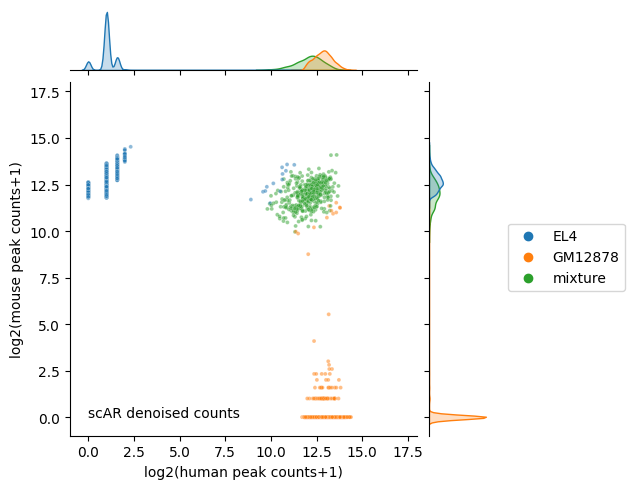

In [22]:
plt.figure(figsize=(2, 2), dpi=150)

ax = sns.jointplot(data=denoised_peaks_scAR,
                   x="log2(human peak counts+1)",
                   y="log2(mouse peak counts+1)",
                   hue='species',
                   hue_order=['EL4', 'GM12878', 'mixture'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   rasterized=True,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'scAR denoised counts');

ax.ax_joint.set_xlim(-1, 18);
ax.ax_joint.set_ylim(-1, 18);
ax.ax_joint.legend(bbox_to_anchor=(1.6, 0.6),borderaxespad=0)